In [1]:
import sys
sys.path.append('../')

import h5py
import numpy as np
import pypostpiv as p3
import matplotlib.pyplot as plt
import ReadIM
import cv2
import scipy.signal
from matplotlib import gridspec
%matplotlib inline

/home/adutta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cnf_t1 = p3.load('ucnf_t1.hdf5')

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE, )          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def rotateImage(image, angle):
  #image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D((-0.0155787,0), angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [5]:
x,y,cnf_t1_mean = cnf_t1.fmean().mag().get_value()

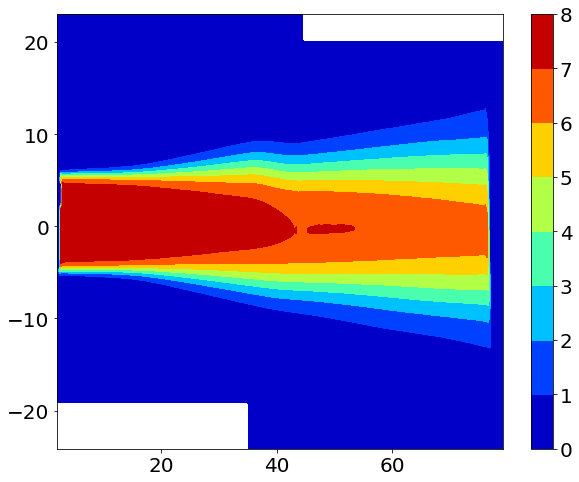

In [6]:
plt.figure(figsize=(10,8))
plt.contourf(x,y,cnf_t1_mean,cmap='jet')
plt.colorbar()

In [9]:
def plot_mean_contours(x,y,array):
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2]) 
    #ax1 = fig.add_subplot(121)
    plt.subplots_adjust(wspace=None, hspace=None)
    c = 180
    d = 180
    level = np.linspace(0,1,11)
    plt.subplot(gs[1])
    plt.subplots_adjust(wspace=None, hspace=None)
    #plt.subplot(1,2,2)
    plt.contourf(x[25:-15,c:-15]/10,y[25:-15,c:-15]/10,array[25:-15,c:-15]/7.4,cmap='jet',levels = level)
    plt.colorbar()
    plt.xlabel('$x/h$')
    plt.tick_params(axis='y',left='off',labelleft='off')
    
    #plt.ylabel('$y/h$')
    #plt.subplot(1,2,1
    plt.subplot(gs[0])
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.contourf(x[25:-15,10:-d]/10,y[25:-15,10:-d]/10,array[25:-15,10:-d]/7.4,cmap='jet',levels = level)
    #plt.colorbar()
    plt.xlabel('$x/h$')
    plt.ylabel('$y/h$')
    return(x[25:-15,10:-d]/10,y[25:-15,10:-d]/10,array[25:-15,10:-d]/7.56)

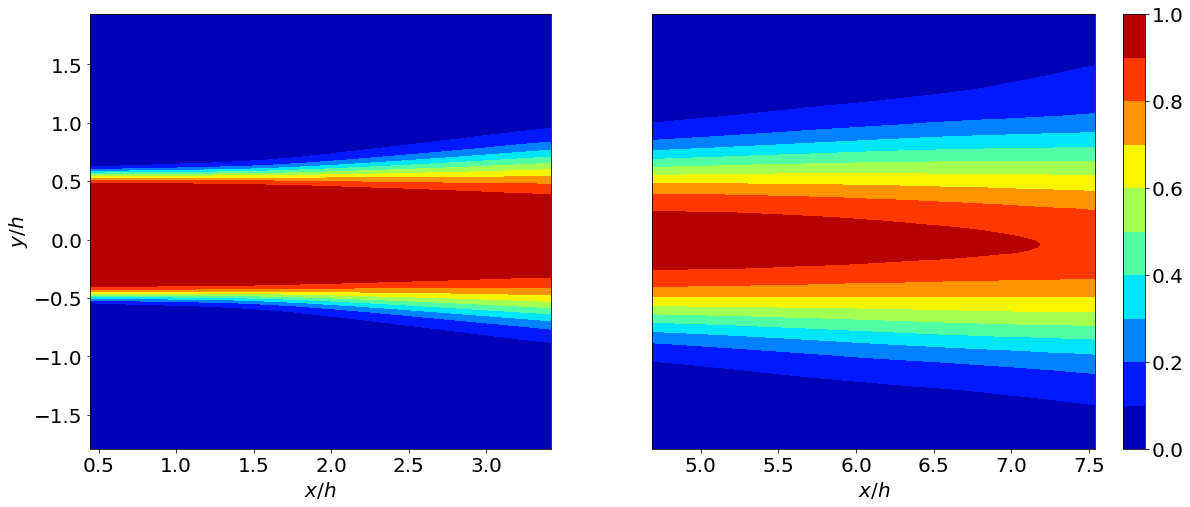

In [10]:
x_arr,y_arr,_arr_arr=plot_mean_contours(x,y,cnf_t1_mean)

In [ ]:
c = 165
d = 145
arr1 = cnf_t1_mean[25:-15,10:-d]
arr2 = cnf_t1_mean[25:-15,c:-15]
arr2 = np.roll(arr2,1,axis=0)
arr2_rot = rotateImage(arr2,0.2)
arr_cat = np.concatenate((arr1,arr2),axis=1)
#arr1.shape,arr2.shape
arr_cat.shape,x.shape,y.shape

In [ ]:
mask = np.zeros((150,5))
x_l = np.linspace(0,5,5)
y_l1 = 0.5*np.cos(x_l) + 0.5
y_l2 = -0.5*np.cos(x_l) + 0.5
mask1 = mask + y_l1

In [ ]:
plt.figure(figsize=(10,8))
x_cat = x[:-40,:-25]
y_cat = y[:-40,:-25]
levels = np.linspace(0,8,9)
plt.contourf(x_cat,y_cat,arr_cat,levels=levels,cmap='jet')
plt.colorbar()

In [ ]:
def plot_cross_profiles(array,z,yrange,ylabel,ymin,ymax,norm):
    plt.figure(figsize = (10,8))
    k = np.arange(150,300,z)
    profiles = []
    for k1 in k:
        x_prof = []
        for i in range(0,190):
            x_prof.append(array[i][k1])
        profiles.append(x_prof)
    for p,k1 in zip(profiles,k):
        plt.plot(np.linspace(ymin,ymax,len(y)-(yrange+20)),np.asarray(p[yrange:-20])/norm,label = 'x = ' + str((k1*0.025))+'h')
    plt.xlabel('$y/h$')
    plt.ylabel(ylabel)
    plt.legend()    
    plt.minorticks_on()
    plt.grid('on')

In [ ]:
plot_cross_profiles(cnf_t1_mean,30,21,'$U/U_{0}$',-2,2,7.56)

In [ ]:
x1,y1,cnf_t1_u_mean = cnf_t1.u(0).fmean().mag().get_value()
x1,y1,cnf_t1_v_mean = cnf_t1.u(1).fmean().mag().get_value()

In [ ]:
cnf_t1_u_time_series = cnf_t1.u(0)[0]
cnf_t1_v_time_series = cnf_t1.u(1)[0]
cnf_t1_u_fluc = []
for i in range(0,cnf_t1_u_time_series.shape[2]):
    z = cnf_t1_u_time_series[:,:,i] - cnf_t1_u_mean
    cnf_t1_u_fluc.append(z)
cnf_t1_v_fluc = []
for i in range(0,cnf_t1_v_time_series.shape[2]):
    z = cnf_t1_v_time_series[:,:,i] - cnf_t1_v_mean
    cnf_t1_v_fluc.append(z)

In [ ]:
cnf_t1_rss = []
for i in range(0,2560):
    z1 = cnf_t1_u_fluc[i]
    z2 = cnf_t1_v_fluc[i]
    cnf_t1_rss.append(z1*z2)

In [ ]:
u2 = 0
for i in range(0,2560):
    u2 = u2 + (cnf_t1_u_fluc[i]*cnf_t1_u_fluc[i])
cnf_t1_u2_avg = u2/2560
cnf_t1_u2_avg = cnf_t1_u2_avg 

In [ ]:
v2 = 0
for i in range(0,2560):
    v2 = v2 + (cnf_t1_v_fluc[i]*cnf_t1_v_fluc[i])
cnf_t1_v2_avg = v2/2560
cnf_t1_v2_avg = cnf_t1_v2_avg 

In [ ]:
s = 0
for i in range(0,2560):
    s = s + cnf_t1_rss[i]
cnf_t1_rss_avg = s/2560
cnf_t1_rss_avg = cnf_t1_rss_avg 

In [ ]:
plot_cross_profiles(cnf_t1_rss_avg,30,0,'$\\overline{u^{\'}v{\'}}$',0,2,1)

In [ ]:
plot_cross_profiles(cnf_t1_u2_avg,30,116,'$\\overline{u^{\'}u{\'}}$',0,2,1)

In [ ]:
plot_cross_profiles(cnf_t1_v2_avg,30,116,'$\\overline{v^{\'}v{\'}}$',0,2,1)

In [ ]:
cnf_t1_fluc_spcl = np.sqrt(cnf_t1_u2_avg + cnf_t1_v2_avg)
plot_cross_profiles(cnf_t1_fluc_spcl,30,116,'$\\sqrt{u^{\'2}+v^{\'2}}$',0,2,1)

In [ ]:
np.arange(150,300,30)

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
g = 118
probe_point_4 = []
for i in range(0,2560):
    z = cnf_t1_u_fluc[i][g][150]
    probe_point_4.append(z)

probe_point_5 = []
for i in range(0,2560):
    z = cnf_t1_u_fluc[i][g][180]
    probe_point_5.append(z)
    
probe_point_6 = []
for i in range(0,2560):
    z = cnf_t1_u_fluc[i][g][240]
    probe_point_6.append(z)

probe_point_7 = []
for i in range(0,2560):
    z = cnf_t1_u_fluc[i][g][270]
    probe_point_7.append(z)


f, Pxx_den4 = scipy.signal.periodogram(probe_point_4, 1000,return_onesided=True,scaling='spectrum')
f, Pxx_den5 = scipy.signal.periodogram(probe_point_5, 1000,return_onesided=True,scaling='spectrum')
f, Pxx_den6 = scipy.signal.periodogram(probe_point_6, 1000,return_onesided=True,scaling='spectrum')
f, Pxx_den7 = scipy.signal.periodogram(probe_point_7, 1000,return_onesided=True,scaling='spectrum')

In [ ]:
Pxx_den4_s = smooth(Pxx_den4,20)
Pxx_den5_s = smooth(Pxx_den5,20)
Pxx_den6_s = smooth(Pxx_den6,20)
Pxx_den7_s = smooth(Pxx_den7,20)

In [ ]:
Pxx_den4_s = Pxx_den4_s/Pxx_den4_s[25:-50].max()
Pxx_den5_s = Pxx_den5_s/Pxx_den5_s[25:-50].max()
Pxx_den6_s = Pxx_den6_s/Pxx_den6_s.max()
Pxx_den7_s = Pxx_den7_s/Pxx_den7_s.max()

In [ ]:
n = 25
m = 250
l = (f*0.01)/7.5
plt.figure(figsize=(12,8))
labels = ['x/h = 3.75','x/h = 4.5','x/h = 6','x/h = 6.75']
plt.semilogy(l[n:-m],Pxx_den4_s[n:-m],label = labels[0])
plt.semilogy(l[n:-m],Pxx_den5_s[n:-m]*10,label = labels[1])
plt.semilogy(l[n:-m],Pxx_den6_s[n:-m]*100,label = labels[2])
plt.semilogy(l[n:-m],Pxx_den7_s[n:-m]*1000,label = labels[3])
#plt.grid('on')
#plt.xlim(0,500)
plt.ylabel('$\\Phi/\\Phi_{max}$')
plt.xlabel('$St$')
#plt.legend(prop={'size': 8})

In [ ]:
array = cnf_t1
time = 500

In [ ]:
x[0,1] - x[0,0]

In [ ]:
array_u_time_series  = array.u(0)[0]
array_v_time_series  = array.u(1)[0]
field_u = array_u_time_series[:,:,time]
field_v = array_v_time_series[:,:,time]
u = field_u
v = field_v
dL = 0.2498
cir0 = u[2:,2:]  + 2*u[1:-1,2:]  + u[:-2,2:]
cir1 = v[2:,2:]  + 2*v[2:,1:-1]  + v[2:,:-2]
cir2 = u[2:,:-2] + 2*u[1:-1,:-2] + u[:-2,:-2]
cir3 = v[:-2,2:] + 2*v[:-2,1:-1] + v[:-2,:-2]

new_field = (cir0+cir1-cir2-cir3)/8/dL
new_field.x = new_field.x[1:-1,1:-1]
new_field.y = new_field.y[1:-1,1:-1]


In [ ]:
c1 = 10
plt.figure(figsize=(10,6))
new_field_clip = new_field[25:-15,c1:-15]
#levels = np.linspace(-0.095,0.095,10)
plt.contourf(x[25:-17,c1:-17]/10,y[25:-17,c1:-17]/10,new_field_clip)
plt.colorbar()

In [ ]:
cnf_t1.dL=0.24

In [ ]:
cnf_t1.dL

In [ ]:
cnf_t1.shape

In [ ]:
x4,y4,s4 = cnf_t1.vorticity('circulation').get_value()

In [ ]:

plt.contourf(x4[25:-15,c1:-15],y4[25:-15,c1:-15],s4[25:-15,c1:-15])
plt.colorbar()

In [ ]:
cnf_t1.vorticity('circulation').shape